In [1]:
#!/bin/python
# read formosa array data and pzfile
# rotate to rtz, lowpass to 1 hz, remove instrument response
# plot sections 2021/06/28 Yin 
# rove map plot 2022.1.14

import os
import glob
import numpy as np
from obspy import read, Stream, UTCDateTime, Trace
from obspy.io.sac import SACTrace
from obspy.io.sac.sacpz import attach_paz

from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

#data = np.genfromtxt('events_lat_lon_dep', dtype=str, encoding='utf-8')
data = np.genfromtxt('events_lat_lon_dep_mt', dtype=str, skip_header=10, encoding='utf-8')
day, time  = data[:,1], data[:,2]
elat, elon, edep = data[:,3].astype(float), data[:,4].astype(float),data[:,5].astype(float)
mt = [[float(row[7]), float(row[8]), float(row[9]), float(row[10]), float(row[11]), float(row[12])] for row in data]
# reading pz file into dict_pz
dict_pz = {}
PZs = os.listdir('PZs')

for pzfile in PZs :
    #print(pzfile)
    station_name = pzfile.split('_')[3]
    if (station_name in dict_pz ):
        continue

    tr = Trace()
    attach_paz(tr, 'PZs/'+pzfile, todisp=True)
    dict_pz[station_name] = tr  #save into dict


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as col
from obspy.imaging.beachball import beach

cpool = ['#FF3333','#FF8800','#00AA00','#33CCFF']
cmap3 = col.ListedColormap(cpool[0:4], 'indexed')

def plot_section(st,st_axi,t1,t2):
    fig = plt.figure(figsize=(8,15))
    comp = ['R','T','Z']
    for i in np.arange(len(comp)):
        plt.subplot(3,1,i+1)
        st.select(channel='BH%s'%(comp[i])).plot(type='section',orientation='horizontal',scale=10,
                  fig=fig,recordstart=t1,recordlength=t2,color='coral')
        st_axi.select(channel='%s'%(comp[i])).plot(type='section',orientation='horizontal',scale=10,
                  fig=fig,recordstart=t1,recordlength=t2,color='black')        
        plt.gca().invert_yaxis()
    
    title= ('%s')%(event_name)
    #fname='PY_PLOT/section_%s_filt_hp_%s_hz_z.png'%(event_name,fmin)
    #title = ('%s \n bandpass %s ~ %s Hz')%(event_name, fmax, fmin)
    fname = 'PY_PLOT/section_%s_filt_bp_%s_%s_hz_z.png'%(event_name,fmax,fmin)
    fname_spec = 'PY_PLOT/Spectrum/%s/section_%s_filt_bp_%s_%s_hz_z.png'%(event_dir,
                event_name,fmax,fmin)
    plt.suptitle(title)
    #plt.savefig(fname, dpi=300,bbox_inches='tight')
    #plt.savefig(fname_spec, dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

In [3]:
import matplotlib.pyplot as plt
from scipy import signal

def plot_seis_specto(tr):
    fig=plt.figure(figsize=(8,7))
    
    p = tr.stats.sac.t0
    #tr.trim(starttime=p-1, endtime=p+4)
    
    plt.subplot(211)
    plt.plot(tr.times(),tr.data)
    plt.axvline(p, ymin=0.15, ymax=0.85, color='tab:red')
    plt.xlim(p-1,p+4)
    
    ax2=plt.subplot(212)
    #win=signal.get_window('hamming',10)
    win= signal.windows.general_gaussian(32, p=1, sig=3)
    #print(win)
    ff, tt, Sxx = signal.spectrogram(tr.data, fs=tr.stats.sampling_rate,
                                     window=win, nperseg=32,noverlap=30,
                                     scaling='spectrum',detrend ='linear')
    #print(tt)
    plt.xlim(p-1,p+4)
    plt.ylim(0,10)
   
    plt.pcolormesh(tt,ff,Sxx ,shading='gouraud',cmap='Blues',vmax=1e-13)
    
    #plt.subplots_adjust(bottom=0.1, right=0.85, top=0.85)
    #cax= plt.axes([0.9,0.1,0.05,0.8])
    #plt.colorbar(cax=cax)
    fname = 'PY_PLOT/Spectrum/%s/%s_%.1f_%s_seim_spectro.png'%(event_dir,
            event_name, tr.stats.distance/1000., tr.stats.station)
    plt.suptitle('%s \n %s.%s \n Epicentral distance %.1f km (%s comp.)'%(event_name, 
                tr.stats.network, tr.stats.station, 
                tr.stats.distance/1000., tr.stats.component),y=1)
    plt.savefig(fname, bbox_inches='tight')
    #plt.show()
    plt.close()


In [4]:
def FILE_trace(dir,sta,net,comp,epi_dis=0):
    file = dir+'/Data_Postprocessing/SEISMOGRAMS/'+sta+'_'+net+'_disp_post_mij_conv0001_'+comp+'.dat'
    data = np.loadtxt(file)
    x,y= data[:,0],data[:,1]
    tr_tmp = Trace(y)
    tr_tmp.stats.starttime=starttime-2
    tr_tmp.stats.delta = x[1]-x[0]
    tr_tmp.stats.channel = comp
    tr_tmp.stats.station = sta
    tr_tmp.stats.network = net
    tr_tmp.stats.distance = epi_dis
    #tr_new = trace_operator(tr_tmp)  #filter 
    tr_tmp.filter("lowpass", freq=1, corners=2, zerophase=True)
    tr_tmp.trim(starttime=starttime, endtime=endtime)
    tr_tmp.detrend("linear").taper(max_percentage=0.05, type='hann')
    return  tr_tmp

/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):
/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


WU13 not in axisem


/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

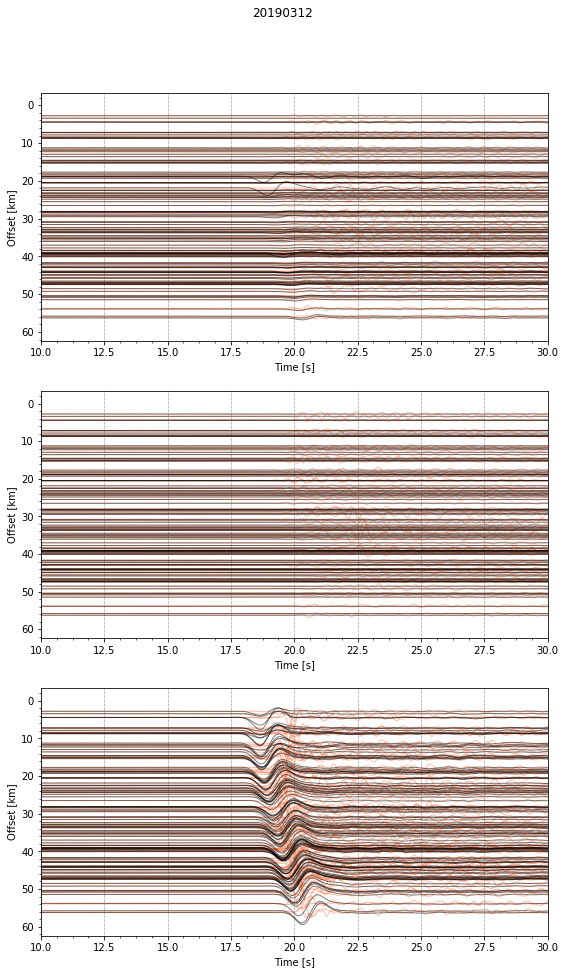

In [5]:
model = TauPyModel(model='prem')
num=[1]
#for i in range(len(day)) :
#for i in np.arange(1) :
for i in num:
    if elat[i] < 24.5:
        continue
    starttime = UTCDateTime(day[i]+time[i])
    endtime=starttime+100
    #20190312_201915
    event_dir = starttime.strftime('%Y%m%d_%H%M%S')
    event_name = starttime.strftime('%Y%m%d')
    axi_dir = '/home/yin/axisem/SOLVER/PREM_1s_tw_locals_%s'%(starttime.strftime('%Y%m%d_%H'))
    sac_bh = glob.glob('%s/*BHE.SAC'%(event_dir))
    st_all = Stream()
    st_axi = Stream()
    
    for sacfile in sac_bh:
        sta = sacfile.split('.')[1]
        st_sta = Stream()
        st_done = Stream()
        st_sta = read('%s/*%s*BH*.SAC'%(event_dir, sta))
        #print(st_sta)
        if (sta not in dict_pz):
            continue
        fmax, fmin = 5, 1
        
        
        paz_sts2 = {'poles': dict_pz[sta].stats.paz['poles'],
                'zeros': dict_pz[sta].stats.paz['zeros'],
                'gain': dict_pz[sta].stats.paz['gain'],
                'sensitivity':dict_pz[sta].stats.paz['sensitivity']}
        st_sta.simulate(paz_remove = paz_sts2)
        dis_m, az, baz = gps2dist_azimuth(elat[i], elon[i], st_sta[0].stats.sac.stla, st_sta[0].stats.sac.stlo)
        epi_dis = locations2degrees(elat[i], elon[i], st_sta[0].stats.sac.stla, st_sta[0].stats.sac.stlo)
        arr_time = model.get_travel_times(source_depth_in_km = edep[i],
                                    distance_in_degree = epi_dis,
                                    phase_list = ['p','s'])
        st_sta.filter('highpass',freq=fmin, corners=2, zerophase = True)
        st_sta.trim(starttime=starttime, endtime=starttime+80)
        st_sta.rotate(method='NE->RT', back_azimuth=baz)
    
        for tr in st_sta:
            sac = SACTrace.from_obspy_trace(tr)
            tr.stats.distance = dis_m
            tr.stats.sac.az = az
            tr.stats.sac.t0 = arr_time[0].time
            tr.stats.sac.kt0 = arr_time[0].name
            #st_all += tr
            sac.evla = elat[i]
            sac.evlo = elon[i]
            sac.evdp = edep[i]
            sac.stdp = 0.
            #sac.stel = 0.
            sac.o = starttime
            sac.iztype = 'io'
            sac.lcalda = True
        
        
        st_all += st_sta.copy()
        
        axi_sta = np.genfromtxt('%s/STATIONS'%(axi_dir),dtype=str)[:,0]
        if ( sta not in axi_sta):
            print(sta,'not in axisem')
            continue
        for comp in ['R','T','Z']:
            tr = FILE_trace(axi_dir,sta,'FM',comp, dis_m)
            st_axi += tr.copy()
    plot_section(st_all, st_axi,10,20)
    
    
    #for tr in st_z:
    #    plot_seis_specto(tr)
    ##plt.show()


/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

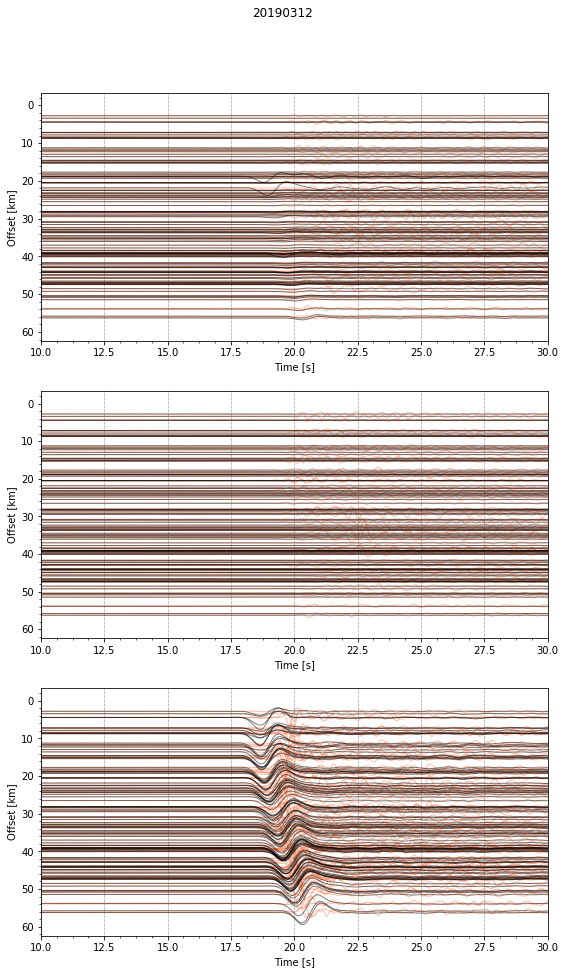

In [9]:
plot_section(st_all, st_axi,10,20)

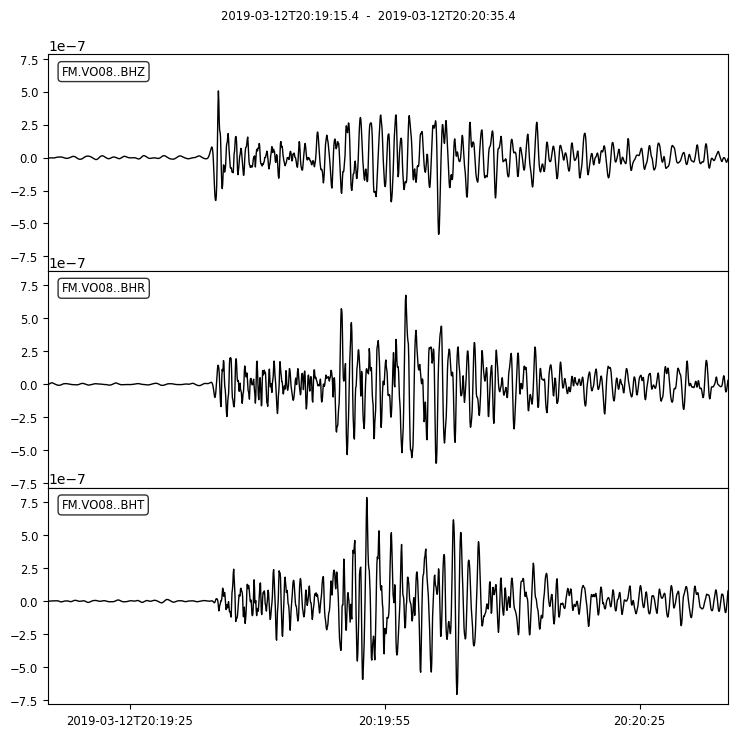

In [6]:
st_all.select(station='VO08').plot()

/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


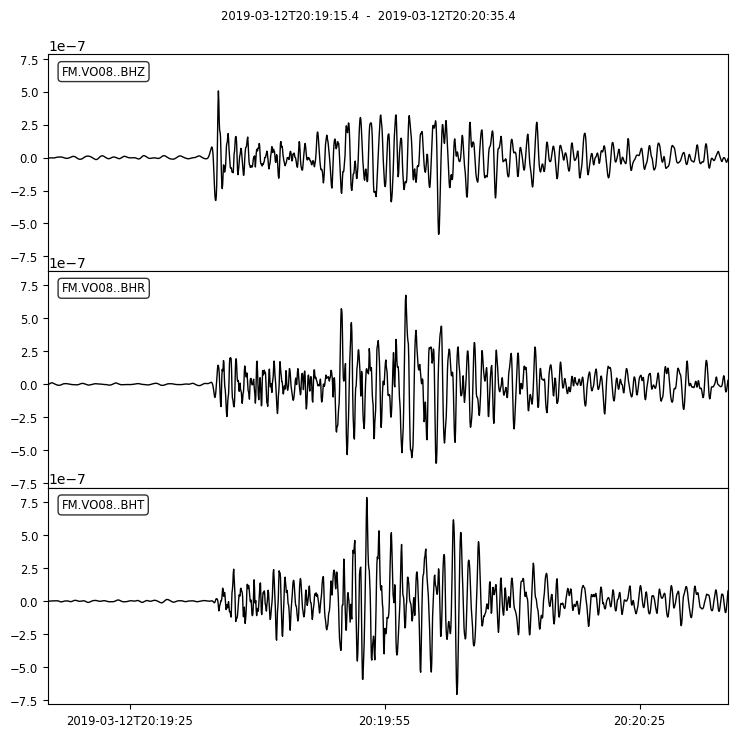

In [22]:
#todisp = True
sta='VO08'
st_single=read('%s/*%s*BH*.SAC'%(event_dir, sta))
paz_sts2 = {'poles': dict_pz[sta].stats.paz['poles'],
        'zeros': dict_pz[sta].stats.paz['zeros'],
        'gain': dict_pz[sta].stats.paz['gain'],
        'sensitivity':dict_pz[sta].stats.paz['sensitivity']}
st_single.simulate(paz_remove = paz_sts2)
dis_m, az, baz = gps2dist_azimuth(elat[i], elon[i], st_single[0].stats.sac.stla, st_single[0].stats.sac.stlo)
epi_dis = locations2degrees(elat[i], elon[i], st_single[0].stats.sac.stla, st_single[0].stats.sac.stlo)
arr_time = model.get_travel_times(source_depth_in_km = edep[i],
                            distance_in_degree = epi_dis,
                            phase_list = ['p','s'])
st_single.filter('highpass',freq=fmin, corners=2, zerophase = True)
st_single.trim(starttime=starttime, endtime=starttime+80)
st_single.rotate(method='NE->RT', back_azimuth=baz)
st_single.plot()

/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


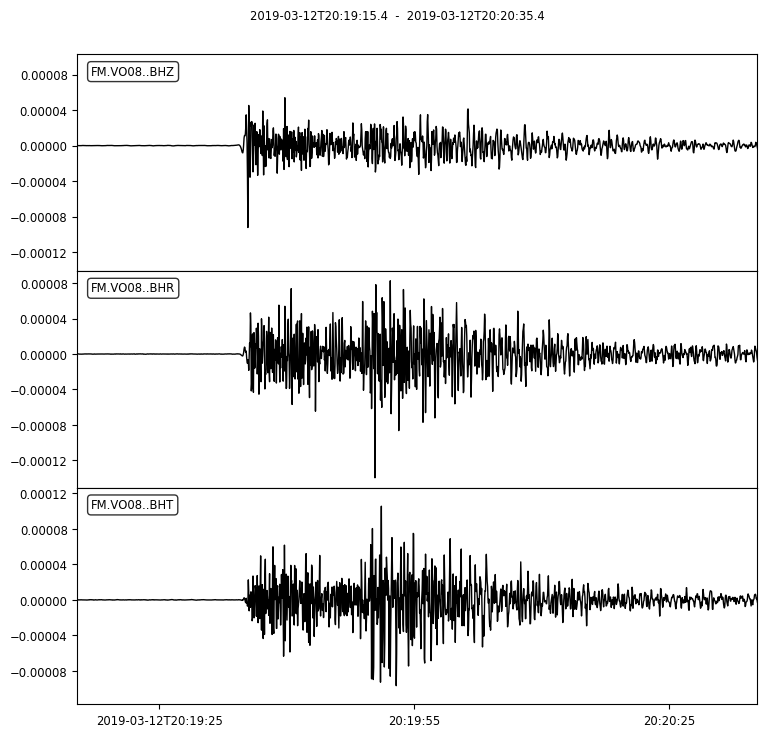

In [25]:
# tovel = true
sta='VO08'
st_single=read('%s/*%s*BH*.SAC'%(event_dir, sta))
paz_sts2 = {'poles': dict_pz[sta].stats.paz['poles'],
        'zeros': dict_pz[sta].stats.paz['zeros'],
        'gain': dict_pz[sta].stats.paz['gain'],
        'sensitivity':dict_pz[sta].stats.paz['sensitivity']}
st_single.simulate(paz_remove = paz_sts2)
dis_m, az, baz = gps2dist_azimuth(elat[i], elon[i], st_single[0].stats.sac.stla, st_single[0].stats.sac.stlo)
epi_dis = locations2degrees(elat[i], elon[i], st_single[0].stats.sac.stla, st_single[0].stats.sac.stlo)
arr_time = model.get_travel_times(source_depth_in_km = edep[i],
                            distance_in_degree = epi_dis,
                            phase_list = ['p','s'])
st_single.filter('highpass',freq=fmin, corners=2, zerophase = True)
st_single.trim(starttime=starttime, endtime=starttime+80)
st_single.rotate(method='NE->RT', back_azimuth=baz)
st_single.plot()

/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


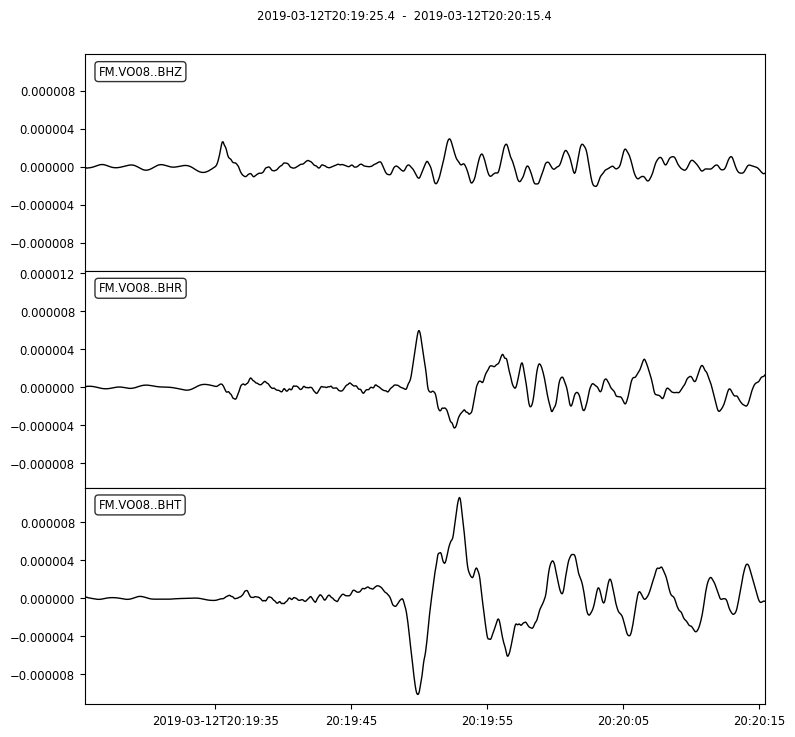

In [7]:
model = TauPyModel(model='prem')
fmin=0.1
sta = 'VO08'
starttime = UTCDateTime(day[1]+time[1])
endtime=starttime+100
#20190312_201915
event_dir = starttime.strftime('%Y%m%d_%H%M%S')
st_check = read('%s/*%s*BH*.SAC'%(event_dir, sta))

st_done, dis_m = fa_data_proc(st_check, sta, 1)
st_done.trim(starttime+10, starttime+60)
st_done.filter('bandpass', freqmax=5, freqmin=0.1)
st_done.plot()

In [ ]:
sta='VO08'
st_single=read('%s/*%s*BH*.SAC'%(event_dir, sta))
paz_sts2 = {'poles': dict_pz[sta].stats.paz['poles'],
        'zeros': dict_pz[sta].stats.paz['zeros'],
        'gain': dict_pz[sta].stats.paz['gain'],
        'sensitivity':dict_pz[sta].stats.paz['sensitivity']}
st_single.simulate(paz_remove = paz_sts2)
dis_m, az, baz = gps2dist_azimuth(elat[i], elon[i], st_single[0].stats.sac.stla, st_single[0].stats.sac.stlo)
epi_dis = locations2degrees(elat[i], elon[i], st_single[0].stats.sac.stla, st_single[0].stats.sac.stlo)
arr_time = model.get_travel_times(source_depth_in_km = edep[i],
                            distance_in_degree = epi_dis,
                            phase_list = ['p','s'])
st_single.filter('highpass',freq=fmin, corners=2, zerophase = True)
st_single.trim(starttime=starttime, endtime=starttime+80)
st_single.rotate(method='NE->RT', back_azimuth=baz)
st_single.plot()

In [6]:
def plot_single_section(st,st_axi,t1,t2):
    fig = plt.figure(figsize=(8,8))
    comp = ['T']
    
    st_real = st.copy()
    freqmax,freqmin = 1,0.01
    st_real.filter('bandpass',freqmax=freqmax, freqmin=freqmin, corners=2, zerophase=True)
    st_real.select(channel='BH%s'%(comp[0])).plot(type='section',orientation='horizontal',scale=6,
              fig=fig,recordstart=t1,recordlength=t2,color='coral')
    st_axi.select(channel='%s'%(comp[0])).plot(type='section',orientation='horizontal',scale=6,
              fig=fig,recordstart=t1,recordlength=t2,color='black')        
    plt.gca().invert_yaxis()
    
    
    #fname='PY_PLOT/section_%s_filt_hp_%s_hz_z.png'%(event_name,fmin)
    title = ('%s \n bandpass %s ~ %s Hz \n %s comp.')%(event_name, freqmax, freqmin,comp[0])
    #fname = 'PY_PLOT/section_%s_filt_bp_%s_%s_hz_z.png'%(event_name,fmax,fmin)
    fname = 'PLOT_axi_real/section_%s_filt_bp_%s_%s_hz_z.png'%(event_name,freqmax, freqmin)
    plt.suptitle(title)
    plt.savefig(fname, dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/userlibs/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

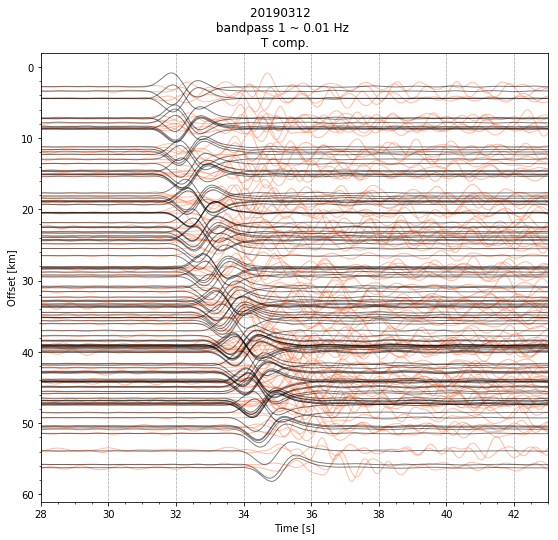

In [7]:
plot_single_section(st_all, st_axi,28,15)

/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


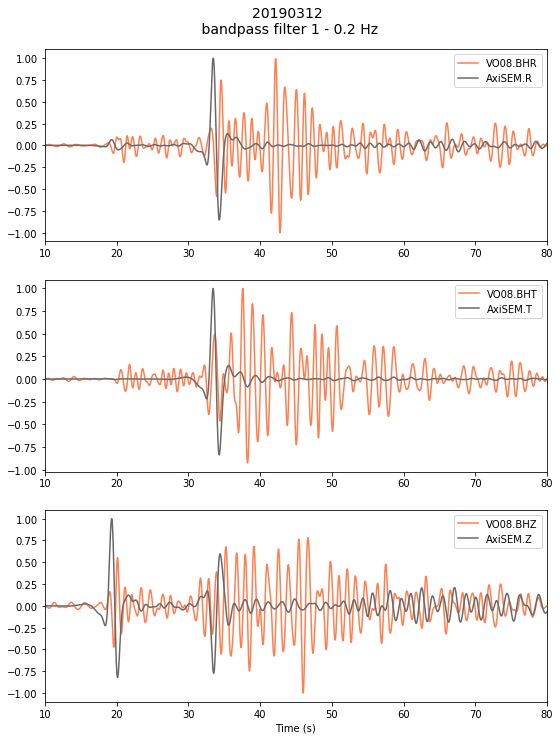

In [12]:
st_real08 = st_all.select(station='VO08').copy()
st_axi08 = st_axi.select(station='VO08').copy()
freqmax, freqmin = 1, 0.2
st_real08.filter('bandpass',freqmax=freqmax, freqmin=freqmin, corners=2, zerophase=True)
st_axi08.filter('bandpass',freqmax=freqmax, freqmin=freqmin, corners=2, zerophase=True)
st_real08.normalize()
st_axi08.normalize()

plt.figure(figsize=(9,12))
comp=['R','T','Z']
for i in np.arange(3):
    
    tr_real = st_real08.select(channel='BH%s'%(comp[i]))[0]
    tr_tmp = st_axi08.select(channel='%s'%(comp[i]))[0]
    
    plt.subplot(3,1,i+1)
    plt.plot(tr_real.times(), tr_real.data,'coral', label='VO08.%s'%(tr_real.stats.channel))
    plt.plot(tr_tmp.times()-0.2, tr_tmp.data , 'dimgray',label='AxiSEM.%s'%(tr_tmp.stats.channel))
    plt.legend()
    #plt.title('%s comp.'%(tr_tmp.stats.channel))
    plt.xlim(10,80)

plt.xlabel('Time (s)')
plt.suptitle('20190312\n bandpass filter %s - %s Hz'%(freqmax,freqmin),y=0.93,fontsize=14)
plt.savefig('PLOT_axi_real/VO08_axi_real_3comp_bp_%s_%s.png'%(freqmax, freqmin),dpi=300,bbox_inches='tight')

In [ ]:
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
from obspy import UTCDateTime
edata = np.genfromtxt('events_lat_lon_dep', dtype=str, encoding='utf-8')
day, time  = edata[:,1], edata[:,2]
elat, elon, edep = edata[:,3].astype(float), edata[:,4].astype(float),edata[:,5].astype(float)

data = np.loadtxt('/home/yin/plot_gmt/plot_poster/fault_one.txt')
flon, flat = data[:,0], data[:,1]

event_dir = []
dist_max = []
dist_min = []
for i in np.arange(len(day)):
    starttime = UTCDateTime(day[i]+time[i])
    print(day[i])
    event_dir.append(starttime.strftime('%Y%m%d_%H%M%S'))
    
    dist_all = []
    for j in np.arange(len(flon)):
        dist_m, az,baz = gps2dist_azimuth(lat1=elat[i],lon1=elon[i],lat2=flat[j],lon2=flon[j])
        dist_all.append(dist_m)
    dist_max.append(max(dist_all)/1000.)
    dist_min.append(min(dist_all)/1000.)

with open('dist_km_eq_shanchiao','w') as f:
    f.write('event min max dist (km) to Shanchiao fault\n')
    for i in np.arange(len(event_dir)):
        f.write(f'{event_dir[i]:s} {dist_min[i]:4.3f} {dist_max[i]:4.3f}\n')

In [18]:
dist_all
print(max(dist_all)/1000.,min(dist_all)/1000.)

2542.338229346316 2493.8294304920737
